## Loading Packages

In [25]:
from fbprophet import Prophet
import numpy as np
import os
from pmdarima.arima import auto_arima, ARIMA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.decomposition import PCA
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from utils import *
import warnings

# plt.style.use('dark_background')
warnings.filterwarnings("ignore")

## Loading Data

In [26]:
def universe_select(path, commodity_name):
    """Selects the instruments believed to be of
    interest for the commodity selected
    Returns: A dictionary of dataframes which are
    intruments of interest"""
    universe_dict = {}
    
    if commodity_name == "Al": 
        aluminium_list = ["al_shfe", "al_lme", "al_comex_p", "al_comex_s", "al_lme_s", "yuan",
                 "bdi", "ted", "vix", "skew", "gsci"]
        
        for instrument in aluminium_list:
            df = pd.read_csv(path + instrument + ".csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
            universe_dict[instrument] = df
            
    elif commodity_name == "Cu":
        copper_list = ["cu_shfe", "cu_lme", "cu_comex_p", "cu_comex_s", "peso", "sol",
                 "bdi", "ted", "vix", "skew", "gsci"]
        
        for instrument in copper_list:
            df = pd.read_csv(path + instrument + ".csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
            universe_dict[instrument] = df
    
    else: print("Select an appropriate commodity")
    return universe_dict


In [27]:
path = "Data/"
universe_dict = universe_select(path, "Cu")

## Preprocessing

In [28]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)
# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)
# Making sure that all the points in the window have consistent lenght
universe_dict = truncate_window_length(universe_dict)
# Generate the full training dataset
df_full = generate_dataset(universe_dict, lg_returns_only=False)

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [29]:
# Visualise the plots
# visualise_universe(universe_dict)
# df_full.head()
df = df_full[["price_cu_shfe"]]
# df = df_full[["lg_return_cu_shfe"]]
# plt.plot(df.index, df)

In [7]:
df.head()

,price_cu_shfe
date,
2006-08-29,68160.0
2006-08-30,67650.0
2006-08-31,67630.0
2006-09-01,70140.0
2006-09-04,71240.0


In [9]:
test_statistic = adfuller(df.price_cu_shfe)
print('p-value: %.3f' % test_statistic[1])
if  test_statistic[1] > 0.05: print("P value is greater than threshold: Differencing required")

p-value: 0.085
P value is greater than threshold: Differencing required


In [10]:
def stationarity_check(df, sig_val=0.05):
  """Check of stationarity using the augmented dickey fuller test
  and find the differening ordered required for stationarity"""
  adf_val = adfuller(df.dropna())
  stationarity = False
  d_val = 0

  while stationarity == False:
    
    if adf_val[1] > sig_val:
      print('Series is Non-Stationary \t(p-value: %.3f)' % adf_val[1])
      stationarity_check(df.diff(), sig_val)
      d_val += 1
      break
      
    else:
      print('Series is Stationary \t\t(p-value: %.3f)' % adf_val[1])
      stationarity = True
  
  return d_val

# print("If p-value is less than, sig val: 0.05 then series is stationary")
# d_val = stationarity_check(df.lg_return_cu_shfe)

In [169]:
# fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# axes[0].plot(df_terms.values)
# plot_acf(df_terms, lags=20, ax=axes[1])
# plot_pacf(df_terms, lags=20, ax=axes[2])

# axes[0].set_title("Price with %i differencing" %d_val) 
# axes[1].set_title("Autocorrelation")
# axes[2].set_title("Partial Correlation")
# plt.show()

In [17]:
# The percentage of the data used for training
train_percentage = 0.8
# Convert string to timestamp
split_date = df.index[int(train_percentage * len(df))]
# Creating the training set
df_train = df.loc[df.index <= split_date].copy()
# Creating the test set
df_test = df.loc[df.index > split_date].copy()

In [242]:
model = auto_arima(df_train.values, trace=True, error_action='ignore', suppress_warnings=True, 
                   n_jobs=-1, stepwise=True)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=42752.440, BIC=42787.808, Fit time=3.453 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=42765.559, BIC=42777.349, Fit time=0.088 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=42757.713, BIC=42775.397, Fit time=0.255 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=42758.276, BIC=42775.960, Fit time=0.246 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=42752.289, BIC=42781.762, Fit time=0.841 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=42748.597, BIC=42772.176, Fit time=1.179 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=42750.590, BIC=42780.063, Fit time=1.701 seconds
Total fit time: 7.771 seconds


In [238]:
model.summary()
print("Model selected:", model.order)

Model selected: (1, 1, 1)


In [243]:
# Forecasting
forecast = model.predict(n_periods=len(df_test))
df_pred = pd.DataFrame(forecast, index = df_test.index,columns=['Prediction'])

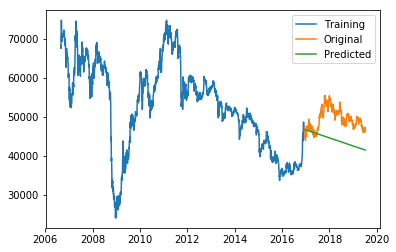

In [24]:
plt.plot(df_train.index, df_train.values, label="Training")
plt.plot(df_test.index, df_test.values, label="Original")
plt.plot(df_test.index, forecast, label="Predicted")
plt.legend()
plt.show()

In [37]:
def log_returns(x, lag=1):
    """Calculate log returns between adjacent close prices"""
    return np.log(x) - np.log(x.shift(lag))

df = df_full[["price_cu_shfe"]]
df_returns = df.apply(log_returns, lag=5)
y = df_returns.shift(-5)
print(df_returns[:10])
print(df[:10])
print(y[:10])
df = df.merge(y, how='right', on=None, left_index=True, right_index=True)
print(df[:10])

            price_cu_shfe
date                     
2006-08-29            NaN
2006-08-30            NaN
2006-08-31            NaN
2006-09-01            NaN
2006-09-04            NaN
2006-09-05       0.050075
2006-09-06       0.089583
2006-09-07       0.101568
2006-09-08       0.058021
2006-09-11       0.007273
            price_cu_shfe
date                     
2006-08-29        68160.0
2006-08-30        67650.0
2006-08-31        67630.0
2006-09-01        70140.0
2006-09-04        71240.0
2006-09-05        71660.0
2006-09-06        73990.0
2006-09-07        74860.0
2006-09-08        74330.0
2006-09-11        71760.0
            price_cu_shfe
date                     
2006-08-29       0.050075
2006-08-30       0.089583
2006-08-31       0.101568
2006-09-01       0.058021
2006-09-04       0.007273
2006-09-05      -0.031614
2006-09-06      -0.062028
2006-09-07      -0.048022
2006-09-08      -0.068628
2006-09-11      -0.027264
            price_cu_shfe_x  price_cu_shfe_y
date               

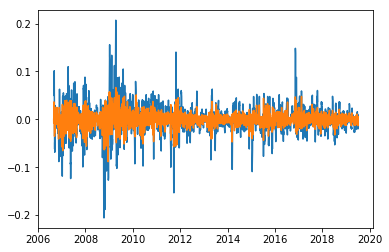

In [264]:
plt.plot(df_returns.index, df_returns)
plt.plot(df_full.index, df_full[["lg_return_cu_shfe"]])

In [22]:
arima = ARIMA(order=(1, 1, 1))
arima.fit(df_train)
forecast = arima.predict(len(df_test))

In [ ]:
def prophet_prediction(df, train_percentage=0.75):
    """Returns a dataframe of out of sample predictions
    trained on a growing percentage of available training data
    """
    # The prediction offset in business days
    week_diff = 5
    month_diff = 22
    quarter_diff = 66

    # The split index is the training percentage but adjusted so 
    # the first prediction date lands on the first date of the test set
    split_index_train = int(train_percentage * len(df)) - quarter_diff
    split_index_test = int(train_percentage * len(df))

    # The date that the test database will begin on
    split_date_test = df["ds"].iloc[split_index_test]
    
    # Creating the test set - This will remain constant
    # even though the training dataset will grow
    # The window size will not be constant 
    df_test = df.loc[df["ds"] >= split_date_test].copy()
    # Making df columns for the predicted values
    df_test["y_pred_week"] = None
    df_test["y_pred_month"] = None
    df_test["y_pred_quarter"] = None
    
    for offset in range(1): #len(df_test.index)
        print("Percentage Complete:", 100* offset/len(df_test.index))
        # Gradually increasing training dataset
        split_date_train = df["ds"].iloc[split_index_train + offset]
        # Creating the training set
        df_train = df.loc[df["ds"] <= split_date_train].copy()

        # Fitting the model
        model = Prophet(daily_seasonality=True)
        # Fit the data to the dataset
        model.fit(df_train)
        
        # Make predictions
        # Starting at the beginning of the test dataset there should be
        # week prediction, month, prediction and quarter prediction
        week_pred_date = df[df.index == [df_train.index[-1] + week_diff]]
        month_pred_date = df[df.index == [df_train.index[-1] + month_diff]]
        quarter_pred_date = df[df.index == [df_train.index[-1] + quarter_diff]]

        week_pred = model.predict(week_pred_date)[["ds", "yhat"]]
        month_pred = model.predict(month_pred_date)[["ds", "yhat"]]
        quarter_pred_date = model.predict(quarter_pred_date)[["ds", "yhat"]]
        # Finding the location in df_test with the date that 
        # we want to fill and setting the predicted value equal to the prediction
        df_test.loc[df_test['ds'] == week_pred.iloc[0]["ds"], 'y_pred_week'] = week_pred["yhat"].values[0]
        df_test.loc[df_test['ds'] == month_pred.iloc[0]["ds"], 'y_pred_month'] = month_pred["yhat"].values[0]
        df_test.loc[df_test['ds'] == quarter_pred_date.iloc[0]["ds"], 'y_pred_quarter'] = quarter_pred_date["yhat"].values[0]
        
    # Renaming the columns
    df_test.rename(columns={'y':"y_true"}, inplace=True)
    return df_test